# Introduction
This notebook illustrastes various methods of stock prediction methods. Most of you already them, but stock prices are a bit tougher to forecast due to market volatility and social influence on the trend of each stock. Thus, the key point in my research is finding the way to combine such methods in oreder to make my predictions flexible, depending on each stock's historical data. I hope you will find this notebook useful!

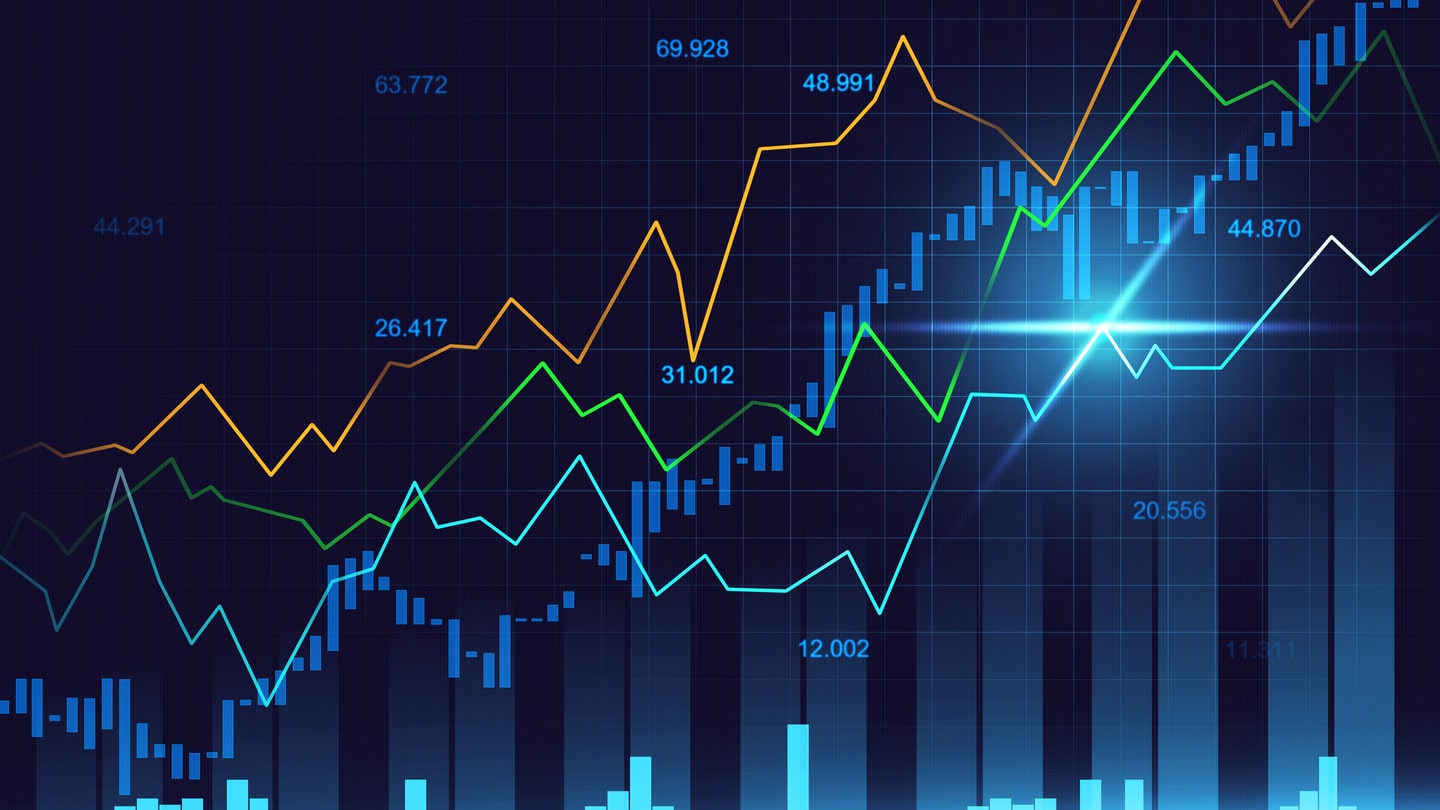
> The stock market refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place.
> A stock or share (also known as a company's "equity") is a financial instrument that represents ownership in a company or corporation and represents a proportionate claim on its assets (what it owns) and earnings (what it generates in profits).

Forecasting the direction of future stock prices is a widely studied topic in many fields including trading, finance, statistics and computer science. The motivation for which is naturally to predict the direction of future prices such that stocks can be bought and sold at profitable positions.

# Table of contents
1. [Installing necessary packages](#1)
1. [Collecting train data](#2)
1. [LSTM](#3)
1. [ARIMA](#4)
1. [Monte Carlo Markov Chain (Metropolis_Hastings method)](#5)
1. [Prediction optimization](#6)
  
1. [Summary](#7)    

# Installing necessary packages

For data scraping I use yfinance package, it is easy to install and use.

> *yfinance is a popular open source library developed by Ran Aroussi as a means to access the financial data available on Yahoo Finance. Yahoo Finance offers an excellent range of market data on stocks, bonds, currencies and cryptocurrencies. It also offers market news, reports and analysis and additionally options and fundamentals data- setting it apart from some of it’s competitors.*

Documentation is available at [Yfinance](https://pypi.org/project/yfinance/)

In [1]:
!pip install yfinance --quiet
!pip install pmdarima --quiet

*PuLP is a python library which can be used to solve linear programming problems.*

PuLP is usually used for simpler tasks, but it can also come handy for predictions blending. By default, CBC solver is used in the package, but there are plenty more of them available, for example, CPLEX, Gurobi and GLPK. For reference, you can see how PuLP is used for optimization tasks in my other notebook: [Optimization problem solving with PuLP](https://www.kaggle.com/equinxx/optimization-problem-solving-with-pulp)

Documentation source: https://coin-or.github.io/pulp/ 

In [2]:
!pip install statsmodels==0.11.0rc1 --quiet
!pip install -Iv pulp==1.6.8 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.2 requires statsmodels!=0.12.0,>=0.11, but you have statsmodels 0.11.0rc1 which is incompatible.
plotnine 0.8.0 requires statsmodels>=0.12.1, but you have statsmodels 0.11.0rc1 which is incompatible.
     |████████████████████████████████| 13.5 MB 32.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Created wheel for pulp: filename=PuLP-1.6.8-py3-none-any.whl size=12269612 sha256=c5e6fab77020c477e9521e11e6cec5e29cd47885ac0b56158a0ccb5a70c22d29
  Stored in directory: /root/.cache/pip/wheels/ef/80/90/298f850e9f5e1f1a41725c8b632c8652f4085a81f2374683db
Successfully built pulp
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.

# Collecting train data

In [3]:
import yfinance as yf

# getting data from Yahoo Finance
stock_name = 'UI'
data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

[*********************100%***********************]  1 of 1 completed


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# LSTM model

Model structure:


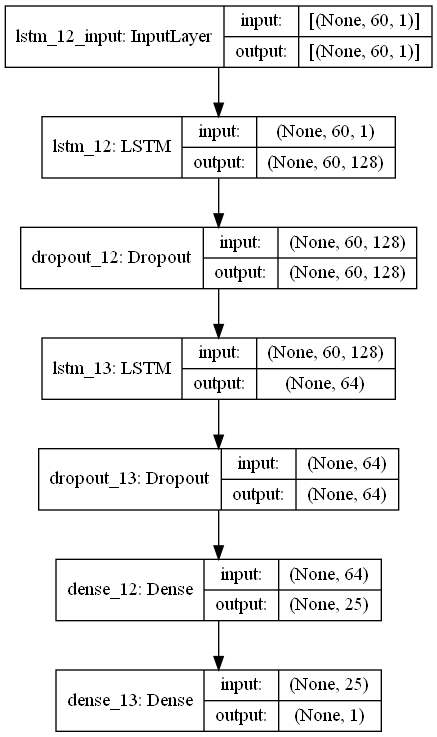

In [5]:
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

def lstm(stock_name, data):
    # Choose only Close price of stock
    data = data.filter(['Close'])
    dataset = data.values
    # Train data - 80%, test - 20%
    training_data_len = int(np.ceil( len(dataset) * .80 ))
    
    # Scale our data from 0 to 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Use our scaled data for training
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.35))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Тrain the model
    model.fit(x_train, y_train, batch_size=1, epochs=21)
    
    # Structure of the model
    keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

    # Create test dataset
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # For finding error we use RMSE formula, but MSE can be used too
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'RMSE LSTM: {rmse}')
    
    # Graphs
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title('Model LSTM')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    
    # Predict stock prices for next moth
    data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

    data_new = data_new.filter(['Close'])
    dataset = data_new.values
    training_data_len = len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    test_data = scaled_data[training_data_len - len(data_new): , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(20, len(test_data)):
        x_test.append(test_data[i-20:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data_new = hist_data_new['Close']
    hist_data_new = np.array(hist_data_new)
    pred_lstm = model.predict(x_test)
    pred_lstm = pred_lstm[:-1]
    pred_lstm = scaler.inverse_transform(pred_lstm)
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.ylabel(f'Prices {stock_name}')
    plt.plot(pred_lstm, label = 'predicted')
    plt.plot(hist_data_new, label = 'historical')
    plt.title(f'{stock_name} predicted price')
    plt.legend()
    plt.show()
    
    return pred_lstm

[array([0.04925131, 0.        , 0.03400406, 0.03174232, 0.00350957,
       0.02390425, 0.02764778, 0.0802527 , 0.07943377, 0.10248011,
       0.09074249, 0.07845888, 0.10579475, 0.07280455, 0.07927781,
       0.09546091, 0.09058647, 0.05786927, 0.08520508, 0.07857586,
       0.08270937, 0.11593353, 0.10684758, 0.12517544, 0.11148805,
       0.08649194, 0.09241927, 0.09659181, 0.09300417, 0.10427387,
       0.21517701, 0.21030257, 0.19630321, 0.17083917, 0.15648886,
       0.15414911, 0.16553578, 0.16604274, 0.18854309, 0.17700046,
       0.17384184, 0.18175792, 0.17477769, 0.1818749 , 0.19875995,
       0.18561843, 0.17949617, 0.19236469, 0.1835127 , 0.18132896,
       0.18905005, 0.18827015, 0.18951798, 0.1307908 , 0.14346433,
       0.13718606, 0.16584776, 0.16288412, 0.15980344, 0.14498515])]
[0.14876771772454356]

[array([0.04925131, 0.        , 0.03400406, 0.03174232, 0.00350957,
       0.02390425, 0.02764778, 0.0802527 , 0.07943377, 0.10248011,
       0.09074249, 0.07845888, 0.10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


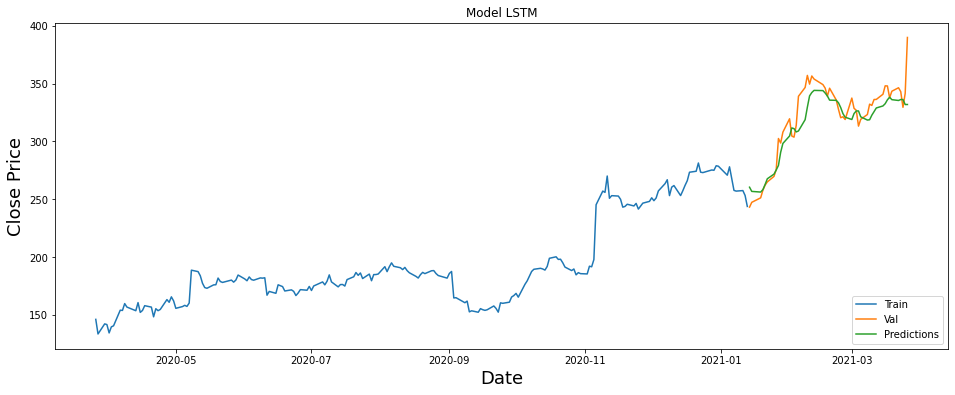

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


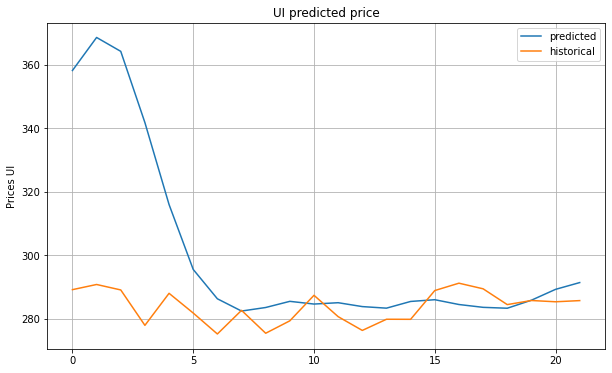

In [6]:
lstm_pred = lstm(stock_name, data)

In [7]:
# Check size of predictions array
print(lstm_pred.shape)

(22, 1)


# ARIMA

*Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.*

*ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.*

Perform ADF test for stock data:

In [8]:
data_adf = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data_adf = data_adf['Close']

from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_adf)

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.8807010250943036, True)

Therefore we can see that data is stationary and we can use regressive models for forecasting. Now we can apply ARIMA (Auto ARIMA)

In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest
from pmdarima.datasets import load_wineind
import random

def arima(stock_name, data):
    df_close = data['Close']
    
    # Split data into train and test set (90% - train, 10% - test)
    df_log = df_close
    #train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    train_data, test_data = df_log[3:int(len(df_log) * 0.9)], df_log[int(len(df_log) * 0.9):]
    test_values = len(df_log) * 0.01 + 1.0

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(train_data, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    plt.show()
    
    model =  pm.auto_arima(df_log,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

    model.summary()

    exo_data = data['Volume']
    exo_data = exo_data[int(len(exo_data) * 0.9):]
    
    preds = model.predict(n_periods = 22, X = exo_data)

    preds = np.vstack(preds)
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    
    rmse = np.sqrt(np.mean(((preds - hist_data) ** 2)))
    print(f'RMSE ARIMA: {rmse}')
    
    plt.plot(hist_data, label='historical')
    plt.plot(preds, label='predictions')
    plt.title(f'{stock_name} prediction for 30 days')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    return preds

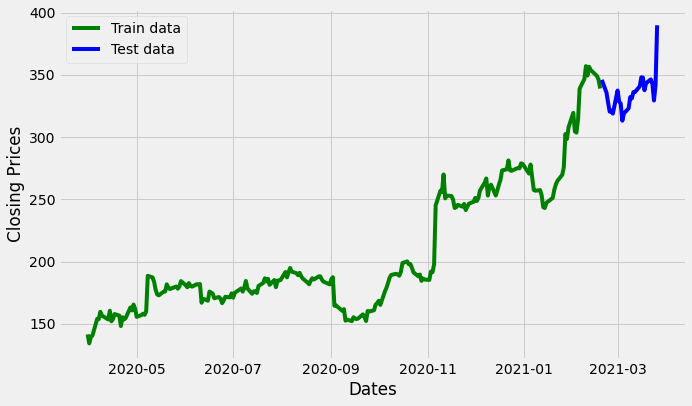

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2156.214, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1774.816, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1967.279, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2176.455, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1831.441, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1753.631, Time=0.47 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=1741.327, Time=1.23 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=1738.029, Time=1.64 sec
 ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=1732.658, Time=4.03 sec
 ARIMA(1,0,0)(5,1,1)[7] intercept   : AIC=1724.648, Time=5.16 sec
 ARIMA(1,0,0)(4,1,1)[7] intercept   : AIC=1724.445, Time=2.37 sec
 ARIMA(1,0,0)(3,1,1)[7] intercept   : AIC=1722.685, Time=1.66 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1721.214, Time=0.82 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1719.369, Time=0.45 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept

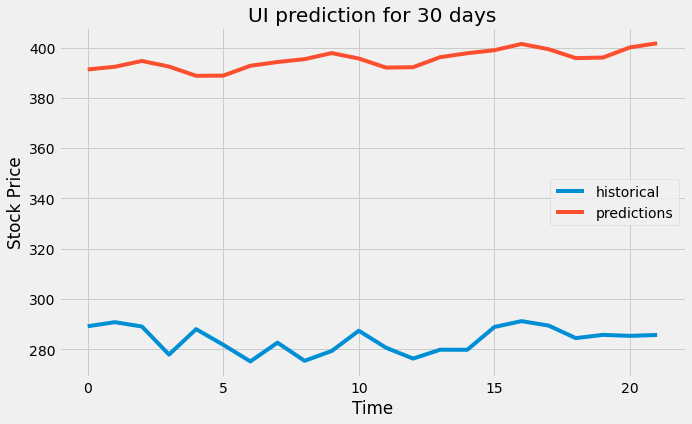

(22, 1)


In [10]:
arima_pred = arima(stock_name, data)
print(arima_pred.shape)

Judging from big difference between real and predicted data we can try use other regressive methods, like SARIMAX or VAR, but they show almost the same results. The reason to that might be high market volatility during prediction period and such methods cannot change forecasting trend for each day. We can test regressive methods on older data and we will see that error is lower.

**SARIMAX**

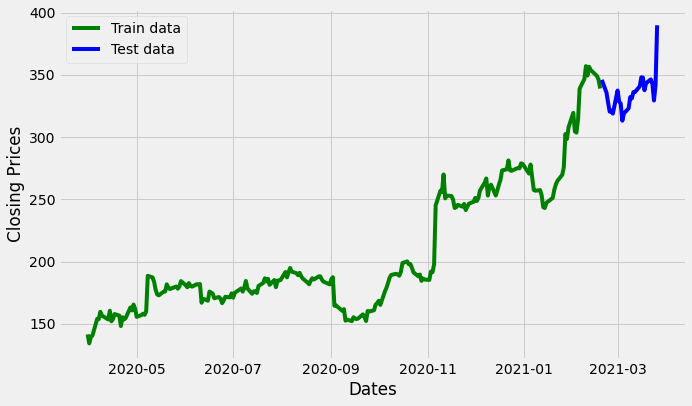

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -741.635
Date:                Sat, 14 Aug 2021   AIC                           1495.269
Time:                        16:48:13   BIC                           1515.712
Sample:                             0   HQIC                          1503.522
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4145      0.440     -0.942      0.346      -1.277       0.448
ar.L2         -0.3125      0.407     -0.768      0.443      -1.110       0.485
ar.L3          0.1528      0.061      2.494      0.0

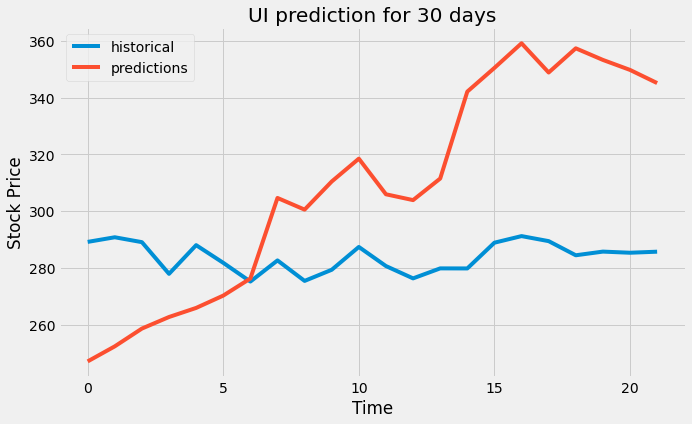

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
data3 = data['Close']
    
# Split data into train and test set (90% - train, 10% - test)
train3_data, test3_data = data3[3:int(len(data3) * 0.9)], data3[int(len(data3) * 0.9):]
test_values = len(data3) * 0.01 + 1.0

exo_data = data['Volume']
exo_data = exo_data[int(len(exo_data) * 0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train3_data, 'green', label='Train data')
plt.plot(test3_data, 'blue', label='Test data')
plt.legend()
plt.show()
    
model = SARIMAX(train3_data, order=(3, 1, 2))

arima_model = model.fit(X = exo_data, disp=-1)

print(arima_model.summary())


preds3 = arima_model.predict(n_periods=22, alpha=0.05)

preds3 = np.vstack(preds3)
preds3 = preds3[-22:]
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)
    
rmse = np.sqrt(np.mean(((preds3 - hist_data) ** 2)))
print(f'RMSE SARIMAX: {rmse}')
    
plt.plot(hist_data, label='historical')
plt.plot(preds3, label='predictions')
plt.title(f'{stock_name} prediction for 30 days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**VAR**

[*********************100%***********************]  1 of 1 completed
rmse value for Close is :  30.697002505089337
[*********************100%***********************]  1 of 1 completed


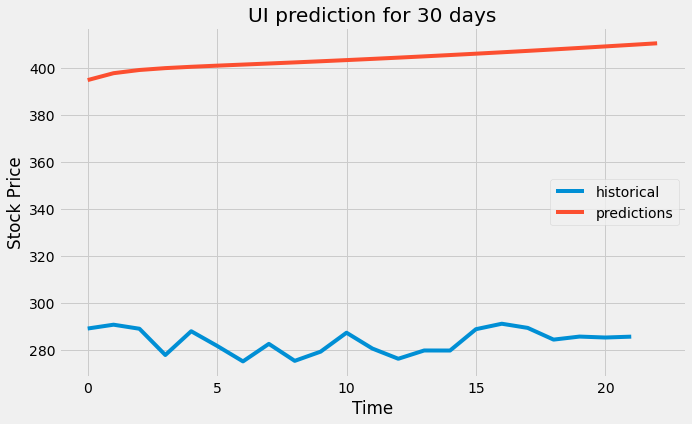

In [12]:
import math
data4 = yf.download(stock_name, start="2020-03-26", end="2021-03-29")
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data4 = data4.drop(['Adj Close'], axis=1)

# Train set - 80%
train4 = data4[:int(0.8*(len(data)))]
valid4 = data4[int(0.8*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model4 = VAR(endog=train4)
model4_fit = model4.fit(trend = 'ctt')

# make prediction on validation
prediction = model4_fit.forecast(model4_fit.y, steps=len(valid4))
pred4 = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,5):
    for i in range(0, len(prediction)):
        pred4.iloc[i][j] = prediction[i][j]

# Check rmse
i = 'Close'
print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred4[i], valid4[i])))


model4 = VAR(endog=data4)
model4_fit = model4.fit(trend = 'ct')
yhat = model4_fit.forecast(model4_fit.y, steps=23)
preds = []

i = 0
while i < (len(yhat)):
    pr = yhat[i][3]
    preds.append([pr])
    i = i + 1
#print(preds)
hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)
plt.plot(hist_data, label='historical')
plt.plot(preds, label='predictions')
plt.title(f'{stock_name} prediction for 30 days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Monte Carlo Markov Chain (Metropolings-Hastings method)

> *MCMC allows us to draw samples from any distribution that we can't sample from directly. It can be used to sample from the posterior distribution over parameters. It has seen much success in many applications, such as computing the distribution of parameters, given a set of observations and some prior belief, and also computing high dimensional integrals in physics and in digital communications.*

When applying the Monte Carlo method, there is a problem of obtaining a sample from some multidimensional probability distribution *p(x)*. The solution to this problem is the basis of MKML methods. In particular, there have been attempts to integrate very complex functions with random simulations. The result of these attempts is the Metropolis-Hastings algorithm. 
This algorithm requires the use of a simple distribution, called the proposal distribution *Q(θ'/θ)*, to extract suitable values from the posterior distribution *P(Θ=θ/D)*. 
Metropolis-Hastings method uses *Q* to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This "memoriless" random walk is the "Markov Chain" part of MCMC.

The probability of each new sample is determined by the function *f*. The function *f* must be proportional to the given distribution from which we want to take samples. The function f is usually chosen as a probability density function that expresses this proportionality. To get a new position of the parameter, just take our current one *θ* and propose a new one *θ'*, that is randomly drawn from our distibution *Q(θ'/θ)*. Usually it is a symmetric distribution, for example, a normal distribution with mean *θ* and some standard deviation *σ: Q(θ'/θ) = N(θ,σ)*. The acception criterion for the sample θ' is the formula:

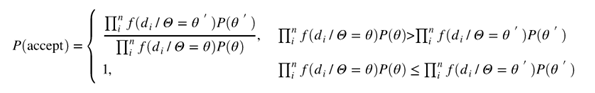

If *θ'* is more likely than the current *θ*, then we always accept *θ'*. If it is less likely than the current *θ*, then we might accept it or reject it randomly with decreasing probability, the less likely it is.

References: 
https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb;
http://janroman.dhis.org/stud/I2010/MCBS/AFI.pdf

For stock predicting using the following method we use stock price formula below, according to Black-Scholes method. That means, that price of stock follows a geometric Brownian motion with constant drift and volatility.

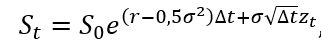

z_t is our random shift indicator, which is generated with MCMC method.
The inputs for the Black-Scholes equation are volatility (in our case 25%), stock price for previous time period and the risk-free interest rate (10%). As we predict prices for each day of next trading month, we use ∆t as 1(day)/22(trading days in month).


In [13]:
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import pandas as pd
import yfinance as yf
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

mu, sig, N = 1.1, 1, 100000
pts = []


def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)
    
    return pts

def MH(stock_name, data):
    hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
    hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    hist_data = hist_data['Close']
    hist_data = np.array(hist_data)
    stock_pred = []
    data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    dt1 = data['Close']
    maturnity = 1
    volatility = 0.25
    risk_free = 0.1
    timestep = 1
    steps = 22
    delta_t = maturnity / steps
    i = 0
    stock_pred.append(dt1[-1])
    while timestep < steps:
        stock_price = stock_pred[-i]
        time_exp = maturnity - delta_t * timestep
        # Generate z_t using MCMC method
        pts = MCMC(N)
        stock_price = stock_price * math.exp(((risk_free - 0.5 * (
            math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
        stock_pred.append(stock_price)
        i = i + 1
        timestep = timestep + 1
    
    rmse = math.sqrt(mean_squared_error(hist_data, stock_pred))
    print(f'RMSE MCMC: {rmse}')
    
    plt.plot(stock_pred, label='predictions')
    plt.plot(hist_data, label = 'historical')
    plt.title(f'{stock_name} prediction for 30 days')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
    return stock_pred

[*********************100%***********************]  1 of 1 completed
RMSE MCMC: 128.8491114568336


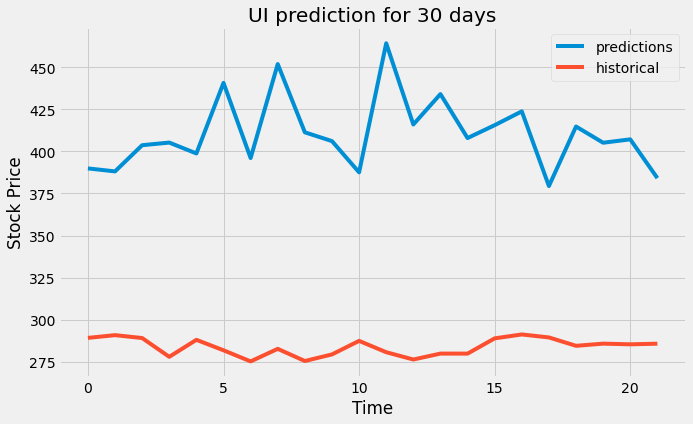

In [14]:
mcmc_pred = MH(stock_name, data)
mcmc_pred = np.vstack(mcmc_pred)

In [15]:
print(mcmc_pred.shape)

(22, 1)


# Prediction optimization

Prediction from 3 models is blended by creating an optimization problem, where target function is RMSE between forecast and historical data for last month: 
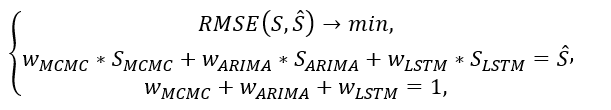

where *S* is the actual data for the prediction period;
*S^* - predicted data for the period;
*W* - weights for the forecasts of each model; 
The output is weighted prediction data which are close to the actual data. The model shown above is solved with PuLP package:

[*********************100%***********************]  1 of 1 completed
model solve
Model status:  Optimal
Optimal_weights:
MINIMIZE
-395.25036285519377*weight_arima + -300.36919888583094*weight_lstm + -410.5160294674831*weight_mcmc + 283.810453935103
SUBJECT TO
_C1: weight_arima + weight_lstm + weight_mcmc <= 1

_C2: weight_arima + weight_lstm + weight_mcmc >= 1

VARIABLES
weight_arima <= 1 Continuous
weight_lstm <= 1 Continuous
weight_mcmc <= 1 Continuous



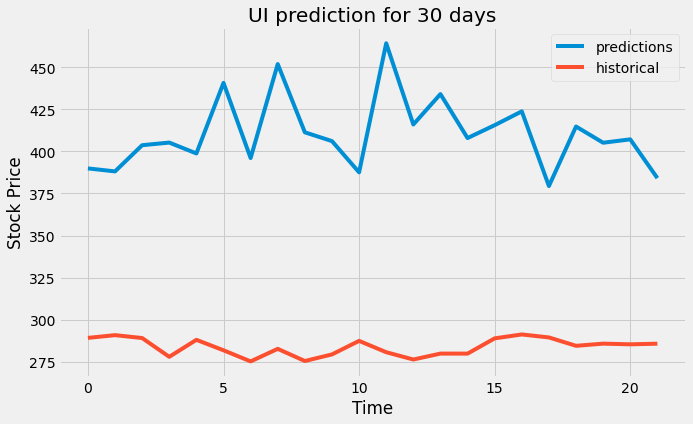

RMSE = 11.256357116437597
MCMC weight: 1.0
ARIMA weight: 1.0000889e-12
LSTM weight: 0.0


In [16]:
import pulp as plp

hist_data = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
hist_data = hist_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
hist_data = hist_data['Close']
hist_data = np.array(hist_data)

preds = []
mse = []
weight_mcmc = 0.3
weight_arima = 0.4
weights_lstm = 0.4

# weights solver
model = plp.LpProblem('Optimal_weights', plp.LpMinimize)
# weights--->variables
weight_mcmc = plp.LpVariable("weight_mcmc", lowBound = 0, upBound=1)
weight_arima = plp.LpVariable("weight_arima", lowBound = 0, upBound=1)
weight_lstm = plp.LpVariable("weight_lstm", lowBound = 0, upBound=1)

for i in range(len(hist_data)):
    preds.append(mcmc_pred[i]*weight_mcmc + arima_pred[i]*weight_arima + lstm_pred[i]*weight_lstm)
    
for i in range (len(hist_data)):
    mse.append(hist_data[i] - preds[i])
# target function--->mean squared error
mse = np.mean(mse)
sum_w = weight_mcmc + weight_arima + weight_lstm

model += mse
model += sum_w <= 1.0
model += sum_w >= 1.0

plp.LpSolverDefault.msg = 1

# solve #
model.solve()
print('model solve')
status = model.solve()
print("Model status: ", plp.LpStatus[status])
print(model)

weight_mcmc_f = weight_mcmc.varValue
weight_arima_f = weight_arima.varValue
weight_lstm_f = weight_lstm.varValue

preds_final = []
# Create final predictions from 3 methods
for i in range(len(hist_data)):
    preds_final.append(mcmc_pred[i]*weight_mcmc_f + arima_pred[i]*weight_arima_f + lstm_pred[i]*weight_lstm_f)
preds_final = np.vstack(preds_final)    
#print(preds_final)
plt.plot(preds_final, label='predictions')
plt.plot(hist_data, label = 'historical')
plt.title(f'{stock_name} prediction for 30 days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

mse = []
for i in range (len(hist_data)):
    mse.append(abs(hist_data[i] - preds_final[i]))
mse = np.mean(mse)
rmse = math.sqrt(mse)
print(f'RMSE = {rmse}')
print(f'MCMC weight: {weight_mcmc_f}')
print(f'ARIMA weight: {weight_arima_f}')
print(f'LSTM weight: {weight_lstm_f}')

# Summary

In this notebook various methods of stock price predicting were tested on historical stock data. Each method has it's own advantages and disavantages, but those can be used for good by blending different methods for generating one prediction. In this case our historical data from last year shows high volatility, so methods like ARIMA lose their efficiency in forecasting. Using our blending method our predictions can be flexible, depending on previous historical data of the stock. 

***If you made it this far, congrats! Thank you for reading this and hope you enjoyed my notebook! Please feel free to comment and upvote :)***